# Tests de ``radial_profile.jl``

## Algo

In [24]:
using Plots, DelimitedFiles

In [26]:
RMIN, RMAX, NBINS = 0.05, 5.0, 100
r = range(RMIN, RMAX, NBINS)

0.05:0.05:5.0

In [25]:
data = readdlm("pru_stack.csv", ',')

100×4 Matrix{Float64}:
 -0.380011   -0.458684  0.765276  0.668167
 -0.413923   -0.427253  0.754848  0.729035
 -0.183909   -0.286828  0.724061  0.726165
 -0.388625   -0.336427  0.752339  0.738918
 -0.0484048  -0.215252  0.778646  0.755632
 -0.239974   -0.224394  0.786689  0.767117
 -0.243534   -0.230705  0.772208  0.768796
 -0.235962   -0.232268  0.769186  0.768912
 -0.322618   -0.256731  0.757021  0.765692
 -0.204179   -0.243673  0.782325  0.769825
 -0.207149   -0.235288  0.776724  0.771409
 -0.241444   -0.236601  0.774743  0.77212
 -0.183507   -0.226024  0.791688  0.776018
  ⋮                               
 -0.225585   -0.21817   0.786966  0.789323
 -0.209903   -0.2179    0.787354  0.789259
 -0.212385   -0.217723  0.788402  0.789232
 -0.21319    -0.217578  0.787902  0.789189
 -0.228347   -0.217918  0.787882  0.789148
 -0.209286   -0.217648  0.787529  0.789097
 -0.220923   -0.217749  0.7894    0.789107
 -0.207659   -0.217441  0.788004  0.789073
 -0.196913   -0.216819  0.788695  0.7890

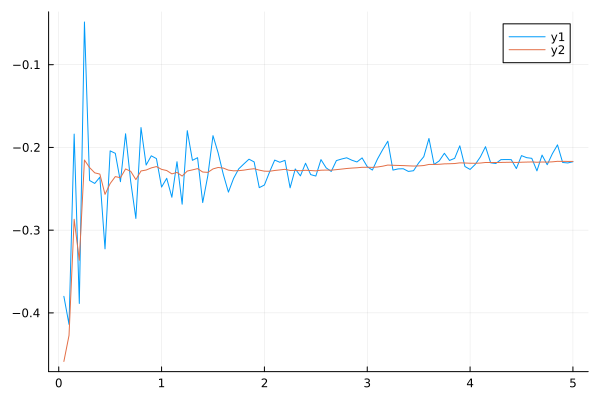

In [28]:
plot(r, data[:,1])
plot!(r, data[:,2])

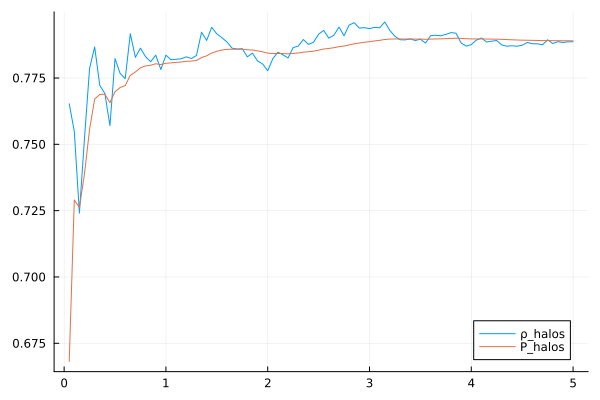

In [29]:
plot(R, data[:,3], label="ρ_halos")
plot!(R, data[:,4], label="Ρ_halos")

## Hexbin para ver los voids

In [ ]:
include("radial_profile.jl")

In [ ]:
RMIN, dr, RMAX = 0.01, 0.05, 5.0
args = (10.0, 11.0, 0.2, 0.25, -1.0, -0.9, 0.2, 100.0)
L = lenscat_load(args...)
tracers_lists = get_tracers(RMAX, L[!,2], L[!,6], L[!,7], L[!,8])

In [ ]:
nvoids = size(L)[1]

In [ ]:
pos = zeros(size(tracers_lists[1])[1], 3)
for j in 1:size(pos)[1]
    pos[j,:] = (tracers_lists[1][j, 4:6] - Vector(L[1, 6:8])) ./ L[1,2]
end

for v in 2:nvoids
    for j in 1:size(tracers_lists[v])[1]
        pos = vcat(pos, ((tracers_lists[v][j, 4:6] - Vector(L[v, 6:8])) ./ L[v,2])' )
    end
end

In [ ]:
logmass = tracers_lists[1][:, 3] .- 12.5

for v in 2:nvoids
    for j in 1:size(tracers_lists[v])[1]
        append!(logmass, tracers_lists[v][j, 3] - 12.5)
    end
end

In [ ]:
tr = hcat(pos, logmass)

In [ ]:
using GLMakie
GLMakie.activate!()

In [ ]:
GLMakie.hexbin(tr[:, 1:2], bins=100, colorscale=log10)

In [ ]:
mask = tr[:,3].^2 .<= (0.1)^2

In [ ]:
# p = GLMakie.hexbin(tr[:, 1][mask], tr[:, 2][mask], bins=100)
p = GLMakie.scatter(tr[:, 1][mask], tr[:, 2][mask], alpha=0.2, color=:blue)
GLMakie.scatter!(0,0,color=:red, alpha=0.7)
display(p)

## Probando paralelizado

In [2]:
using Distributed
using Plots

In [3]:
NCORES = 2

2

In [4]:
addprocs(NCORES-1)
nc = nprocs()
println("NCORES: $nc")

@everywhere begin 
    include("radial_profile.jl")
    include("tools.jl")
    using DelimitedFiles, FITSIO, DataFrames
    using Statistics    
end

NCORES: 2


In [14]:
@everywhere begin 
    RMIN, RMAX, NBINS = 0.05, 5.0, 100
    Rv_min, Rv_max, z_min, z_max, rho1_min, rho1_max, rho2_min, rho2_max, flag = 10.0, 12.0, 0.2, 0.4, -1.0, -0.9, 0.0, 100.0, 2
    lensname = "/home/franco/FAMAF/Lensing/cats/MICE/voids_MICE.dat"
    tracname = "/home/franco/FAMAF/Lensing/cats/MICE/mice_halos_cut.fits"
    # lensname = "/mnt/simulations/MICE/voids_MICE.dat"
    # tracname = "/home/fcaporaso/cats/MICE/mice_halos_centralesF.fits"
end

In [15]:
@everywhere begin
    S = traccat_load(z_min, z_max, tracname=tracname)
    L = lenscat_load(Rv_min, Rv_max, z_min, z_max, rho1_min, rho1_max, rho2_min, rho2_max, flag=flag, lensname=lensname)
    nvoids = size(L)[1]
    i = 1:nvoids
end

In [17]:
nvoids

3057

In [16]:
resmap = pmap(partial_profile, fill(RMIN,nvoids), fill(RMAX,nvoids), fill(NBINS,nvoids), L[i,2], L[i,6], L[i,7], L[i,8], batch_size=NCORES)

3057-element Vector{Tuple{Vector{Float64}, Vector{Float64}, Float64, Int64}}:
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.891145860638528e10, 1.0834268039194748e11  …  1.8257597169076714e12, 9.59739386440105e11, 3.4839404581314385e12, 8.647825223207188e11, 9.647382972246409e11, 3.5172068709159243e12, 2.82502655868409e13, 3.748800640460625e12, 2.1886908649033195e13, 1.3768530306831426e12], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0  …  15.0, 12.0, 15.0, 12.0, 6.0, 9.0, 11.0, 11.0, 13.0, 16.0], 1.5171482739112762e15, 3966)
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  2.5519562190567964e12, 4.059501935798779e12, 8.029798455239946e11, 1.4462117048861863e12, 1.5116709221952244e12, 6.690386346534248e11, 1.0541043588197704e12, 1.3609889801807424e12, 7.112551794648406e11, 1.1981601754279043e12], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  12.0, 15.0, 12.0, 11.0, 19.0, 10.0, 22.0, 16.0, 11.0, 16.0], 1.5310933061875615e15, 5949)
 ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [41]:
mass_p   = zeros(NBINS, nvoids)
NHalos_p = zeros(NBINS, nvoids)
MassBall_p  = zeros(nvoids)
HalosBall_p = zeros(nvoids)

for l in 1:nvoids
    for j in eachindex(resmap)
        mass_p[:,l]    += resmap[j][1]
        NHalos_p[:,l]  += resmap[j][2]
        MassBall_p[l]  += resmap[j][3]
        HalosBall_p[l] += resmap[j][4]
    end
end

In [19]:
mass = vec(sum(mass_p, dims=2))
masscum = cumsum(mass)
NHalos = vec(sum(NHalos_p, dims=2))
NHalosCum = cumsum(NHalos)
MassBall = sum(MassBall_p)
HalosBall = sum(HalosBall_p)

DR = (RMAX-RMIN)/NBINS

MeanDen = MassBall/(4pi/3 * (2RMAX)^3)
MeanHalos = HalosBall/(4pi/3 * (2RMAX)^3)

Delta    = zeros(NBINS)
DeltaCum = zeros(NBINS)
DenHalos = zeros(NBINS)
DenHalosCum = zeros(NBINS)
for k in 1:NBINS
    Vol = (4pi/3) * ((k*DR + RMIN)^3 - ((k-1.0)*DR + RMIN)^3)
    Delta[k] = (mass[k]/Vol)/MeanDen - 1.0
    DenHalos[k] = (NHalos[k]/Vol)/MeanHalos

    Vol = (4pi/3) * (k*DR + RMIN)^3
    DeltaCum[k] = ((masscum[k])/Vol)/MeanDen - 1.0
    DenHalosCum[k] = ((NHalosCum[k])/Vol)/MeanHalos
end

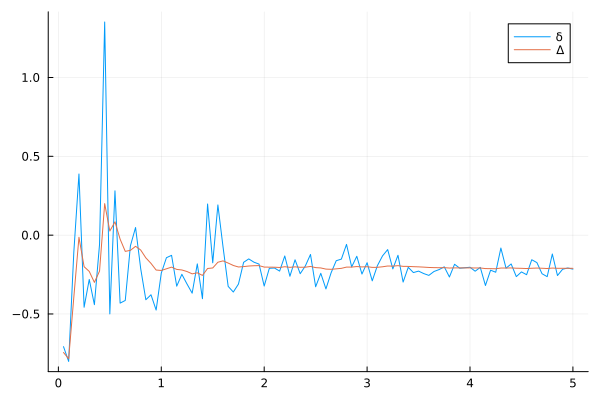

In [20]:
R = range(RMIN,RMAX,NBINS)
plot(R, Delta, label="δ")
plot!(R, DeltaCum, label="Δ")

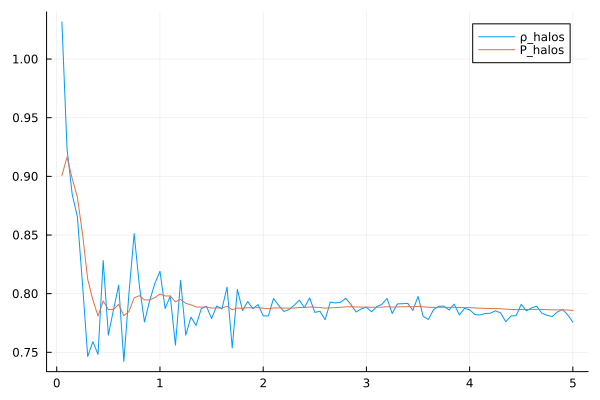

In [21]:
plot(R, DenHalos, label="ρ_halos")
plot!(R, DenHalosCum, label="Ρ_halos")

In [39]:
vol = (4pi/3) * [(k*DR + RMIN)^3 - ((k-1.0)*DR + RMIN)^3 for k in 1:NBINS]
Delta_ind = zeros(NBINS, nvoids)
for j in 1:nvoids
    Delta_ind = mass_p[:,] / vol 

LoadError: DimensionMismatch: Both inputs should have the same number of columns

In [43]:
mass_p

100×3057 Matrix{Float64}:
 1.09573e12  1.09573e12  1.09573e12  …  1.09573e12  1.09573e12  1.09573e12
 2.01148e12  2.01148e12  2.01148e12     2.01148e12  2.01148e12  2.01148e12
 1.75039e13  1.75039e13  1.75039e13     1.75039e13  1.75039e13  1.75039e13
 4.49016e13  4.49016e13  4.49016e13     4.49016e13  4.49016e13  4.49016e13
 2.61654e13  2.61654e13  2.61654e13     2.61654e13  2.61654e13  2.61654e13
 4.83581e13  4.83581e13  4.83581e13  …  4.83581e13  4.83581e13  4.83581e13
 5.00176e13  5.00176e13  5.00176e13     5.00176e13  5.00176e13  5.00176e13
 1.08099e14  1.08099e14  1.08099e14     1.08099e14  1.08099e14  1.08099e14
 3.37259e14  3.37259e14  3.37259e14     3.37259e14  3.37259e14  3.37259e14
 8.76195e13  8.76195e13  8.76195e13     8.76195e13  8.76195e13  8.76195e13
 2.68993e14  2.68993e14  2.68993e14  …  2.68993e14  2.68993e14  2.68993e14
 1.41075e14  1.41075e14  1.41075e14     1.41075e14  1.41075e14  1.41075e14
 1.6941e14   1.6941e14   1.6941e14      1.6941e14   1.6941e14   1.6941e14


## Probando el coso entero...

In [1]:
include("main.jl")

......................
Reading lenses with:
Rvmin......: 10.0 Mpc
Rvmax......: 12.0 Mpc
zmin.......: 0.2
zmax.......: 0.25
rho1min....: -1.0
rho1max....: -0.8
rho2min....: -1.0
rho2max....: 100.0
Done!
......................
Reading halos...
Done!
......................
Calculating profile for:
Nvoids.....: 730
RMIN.......: 0.05
RMAX.......: 5.0
NBINS......: 100
NCORES.....: 4
Vuelta 1 de 4


LoadError: LoadError: On worker 4:
MethodError: no method matching partial_profile(::Float64, ::Float64, ::Int64, ::Float64, ::Float64, ::Float64, ::Float64, ::Float64)

[0mClosest candidates are:
[0m  partial_profile(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any) (method too new to be called from this world context.)
[0m[90m   @[39m [36mMain[39m [90m~/ICE/jl_flagship/[39m[90m[4mradial_profile.jl:129[24m[39m

Stacktrace:
 [1] [0m[1m#235[22m
[90m   @[39m [90m~/.julia/juliaup/julia-1.10.5+0.x64.linux.gnu/share/julia/stdlib/v1.10/Distributed/src/[39m[90m[4mpmap.jl:157[24m[39m
 [2] [0m[1m#invokelatest#2[22m
[90m   @[39m [90m./[39m[90m[4messentials.jl:892[24m[39m
 [3] [0m[1minvokelatest[22m
[90m   @[39m [90m./[39m[90m[4messentials.jl:889[24m[39m
 [4] [0m[1m#110[22m
[90m   @[39m [90m~/.julia/juliaup/julia-1.10.5+0.x64.linux.gnu/share/julia/stdlib/v1.10/Distributed/src/[39m[90m[4mprocess_messages.jl:287[24m[39m
 [5] [0m[1mrun_work_thunk[22m
[90m   @[39m [90m~/.julia/juliaup/julia-1.10.5+0.x64.linux.gnu/share/julia/stdlib/v1.10/Distributed/src/[39m[90m[4mprocess_messages.jl:70[24m[39m
 [6] [0m[1m#109[22m
[90m   @[39m [90m~/.julia/juliaup/julia-1.10.5+0.x64.linux.gnu/share/julia/stdlib/v1.10/Distributed/src/[39m[90m[4mprocess_messages.jl:287[24m[39m
in expression starting at /home/franco/ICE/jl_flagship/main.jl:156